In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip install -q seaborn
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
BATCH_SIZE = 32
n_classes = 4

# Resnet50 base model
conv_base = ResNet50(input_shape= (224,224,3), weights='imagenet', include_top=False)

# Freeze all layers except the last two
for layer in conv_base.layers:
    layer.trainable = False

# Top model
top_model = Flatten()(conv_base.output)
output_layer = Dense(n_classes, activation='softmax')(top_model)

# Final Model
model = Model(inputs=conv_base.input, outputs=output_layer)

In [2]:
def plot_random_images(generator, num_images=20):
    # Get a batch of data from the generator
    images, labels = next(generator)

    # Get random indices for selecting images
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)

    # Plot the selected images
    fig, axs = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Random 20 Images from the Generator', fontsize=16)

    for i, ax in enumerate(axs.flatten()):
        index = random_indices[i]
        image = images[index]
        label = labels[index]
        
        # Ensure pixel values are in valid range [0, 1]
        image = np.clip(image, 0, 1)

        # Display the image
        ax.imshow(image)
        ax.set_title(f'Class: {np.argmax(label)}')
        ax.axis('off')

    plt.show()

In [3]:
data_path = 'datasetmri'

Found 7023 images belonging to 4 classes.


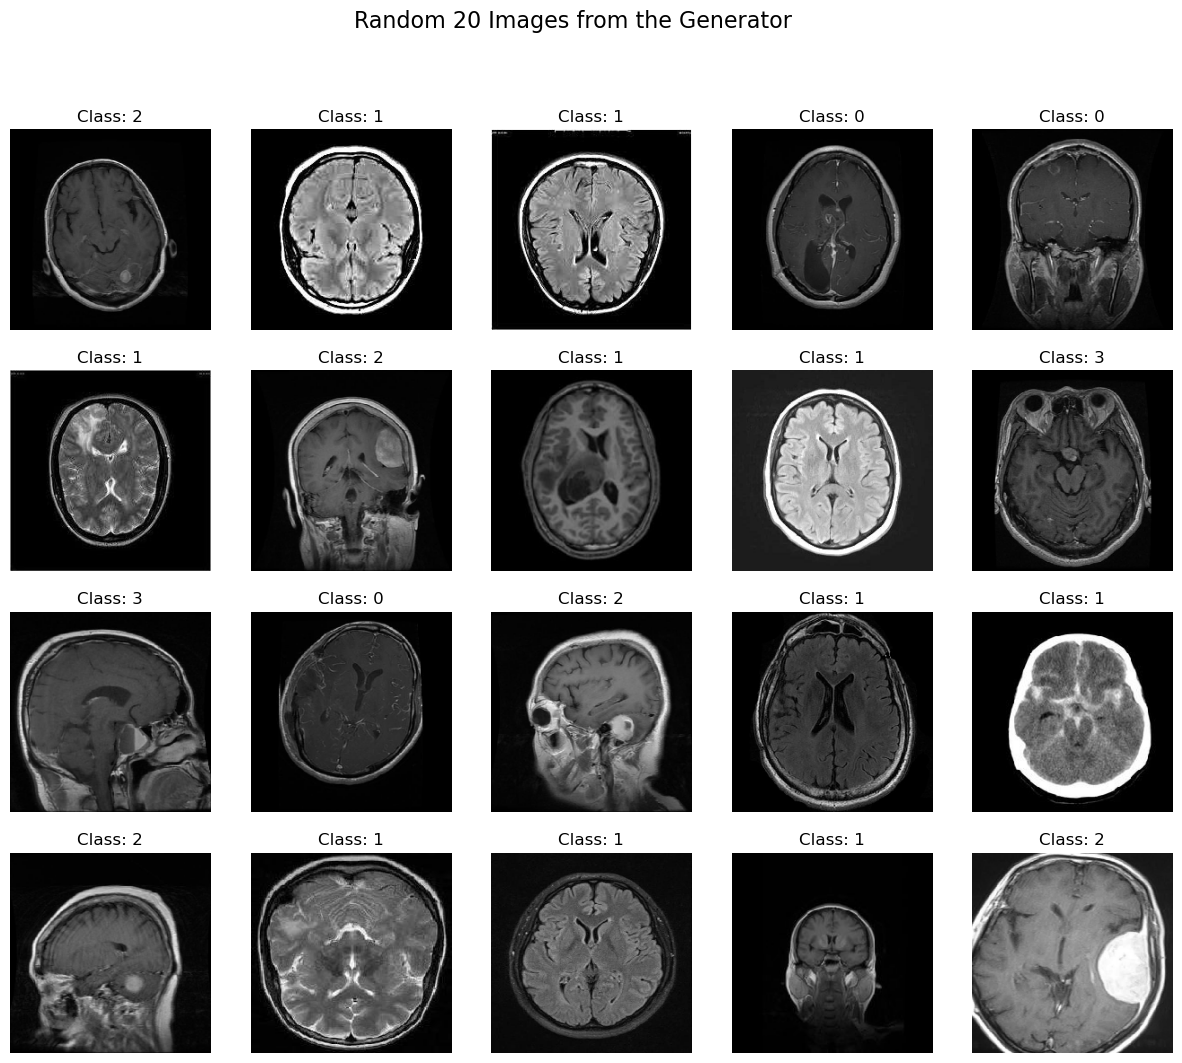

In [4]:
original_data = ImageDataGenerator(rescale=1./255).flow_from_directory(data_path, target_size = (224, 224), batch_size = BATCH_SIZE, class_mode="categorical")
plot_random_images(original_data)

Found 7023 images belonging to 4 classes.


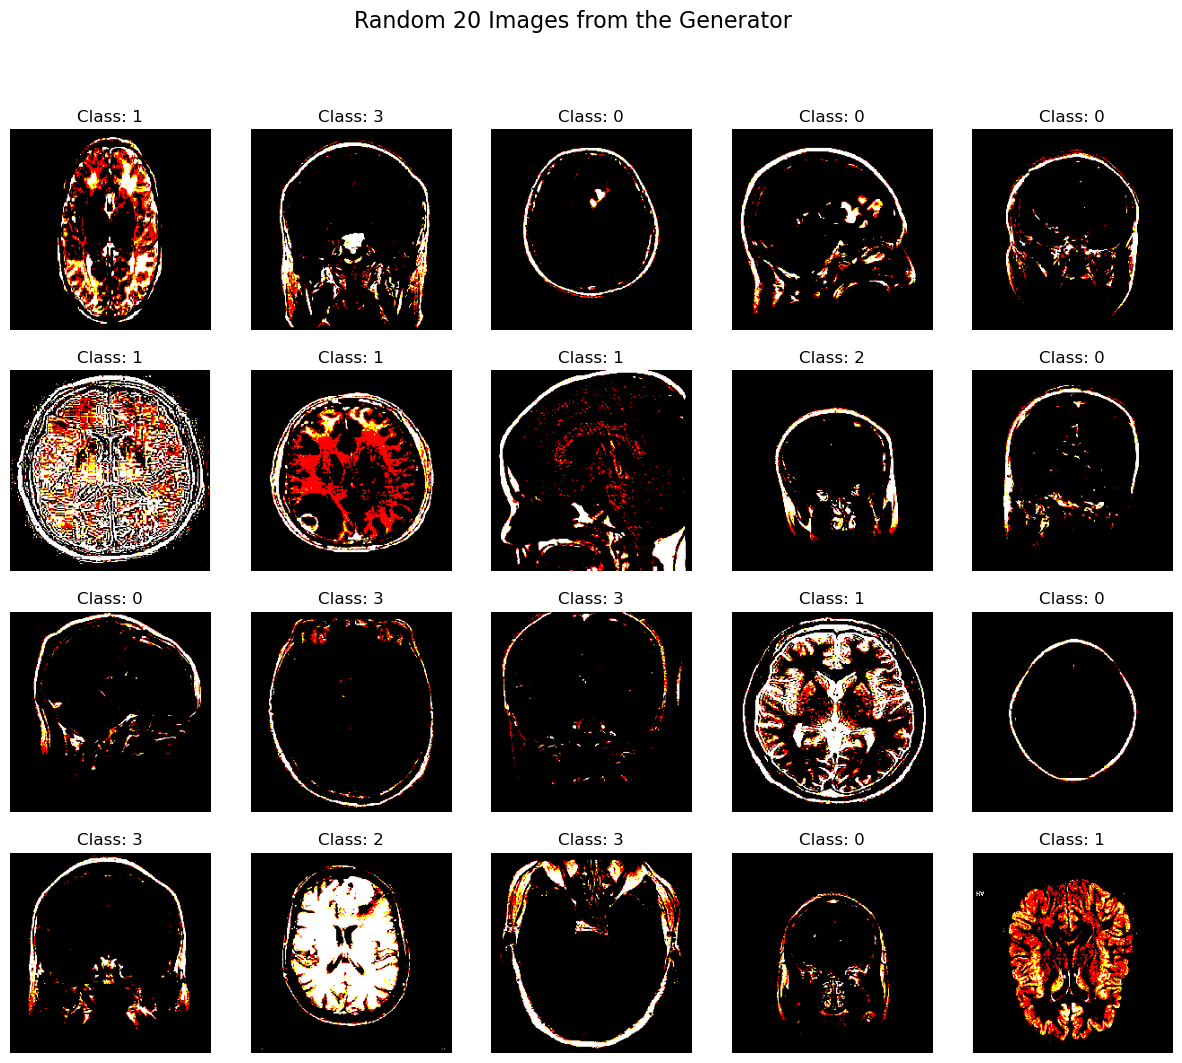

In [5]:
gen_train = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing
full_data = gen_train.flow_from_directory(data_path, target_size = (224, 224), batch_size = BATCH_SIZE, class_mode="categorical")
plot_random_images(full_data)

In [6]:
# Extract filenames and labels from the DirectoryIterator
filenames = full_data.filenames
labels = full_data.labels
class_mapping = {value: str(key) for key, value in full_data.class_indices.items()}
labels = [class_mapping[label] for label in labels]

filenames[:5], labels[:5]

(['glioma\\0000.jpg',
  'glioma\\0001.jpg',
  'glioma\\0002.jpg',
  'glioma\\0003.jpg',
  'glioma\\0004.jpg'],
 ['glioma', 'glioma', 'glioma', 'glioma', 'glioma'])

In [7]:
# Split the data into training and testing sets
train_filenames, test_filenames, train_labels, test_labels = train_test_split(
    filenames, labels, test_size=0.1, random_state=42)

# Create DataFrames for training and testing
train_df = pd.DataFrame({'filename': train_filenames, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_filenames, 'class': test_labels})

# Create separate generators for training and testing using flow_from_dataframe
train_data = gen_train.flow_from_dataframe(train_df, directory=data_path, target_size=(224, 224),
                                           batch_size=BATCH_SIZE, class_mode="categorical",
                                           shuffle=True, seed=42)

test_data = gen_train.flow_from_dataframe(test_df, directory=data_path, target_size=(224, 224),
                                          batch_size=BATCH_SIZE, class_mode="categorical",
                                          shuffle=False)

Found 6320 validated image filenames belonging to 4 classes.
Found 703 validated image filenames belonging to 4 classes.


In [8]:
num_epochs = 200
opt = Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt, 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
checkpoint = ModelCheckpoint(
    filepath='model.resnet50.h5',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
early = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [10]:
n_steps = train_data.samples // BATCH_SIZE
n_val_steps = test_data.samples // BATCH_SIZE
n_steps, n_val_steps

(197, 21)

In [11]:
result = model.fit(
    train_data, 
    epochs=num_epochs, 
    steps_per_epoch=n_steps,
    validation_data=test_data, 
    validation_steps=n_val_steps,
    callbacks=[early, checkpoint, reduce_lr]
)

Epoch 1/200
197/197 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.8750
Epoch 1: val_loss improved from inf to 0.17084, saving model to model.resnet50.h5
197/197 [==============================] - 99s 473ms/step - loss: 0.4008 - accuracy: 0.8750 - val_loss: 0.1708 - val_accuracy: 0.9509 - lr: 1.0000e-04
Epoch 2/200
197/197 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9730
Epoch 2: val_loss improved from 0.17084 to 0.14135, saving model to model.resnet50.h5
197/197 [==============================] - 48s 244ms/step - loss: 0.0703 - accuracy: 0.9730 - val_loss: 0.1413 - val_accuracy: 0.9568 - lr: 1.0000e-04
Epoch 3/200
197/197 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9946
Epoch 3: val_loss improved from 0.14135 to 0.12986, saving model to model.resnet50.h5
197/197 [==============================] - 57s 290ms/step - loss: 0.0178 - accuracy: 0.9946 - val_loss: 0.1299 - val_accuracy: 0.9583 - lr: 1.0000e-04
Ep

Epoch 27/200
197/197 [==============================] - ETA: 0s - loss: 1.1820e-04 - accuracy: 1.0000
Epoch 27: val_loss did not improve from 0.07639
197/197 [==============================] - 81s 410ms/step - loss: 1.1820e-04 - accuracy: 1.0000 - val_loss: 0.0786 - val_accuracy: 0.9777 - lr: 1.0000e-04
Epoch 28/200
197/197 [==============================] - ETA: 0s - loss: 1.0615e-04 - accuracy: 1.0000
Epoch 28: val_loss did not improve from 0.07639
197/197 [==============================] - 82s 415ms/step - loss: 1.0615e-04 - accuracy: 1.0000 - val_loss: 0.0772 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 29/200
197/197 [==============================] - ETA: 0s - loss: 9.7598e-05 - accuracy: 1.0000
Epoch 29: val_loss did not improve from 0.07639
197/197 [==============================] - 83s 419ms/step - loss: 9.7598e-05 - accuracy: 1.0000 - val_loss: 0.0782 - val_accuracy: 0.9777 - lr: 1.0000e-04
Epoch 30/200
197/197 [==============================] - ETA: 0s - loss: 8.6293e-05 - 

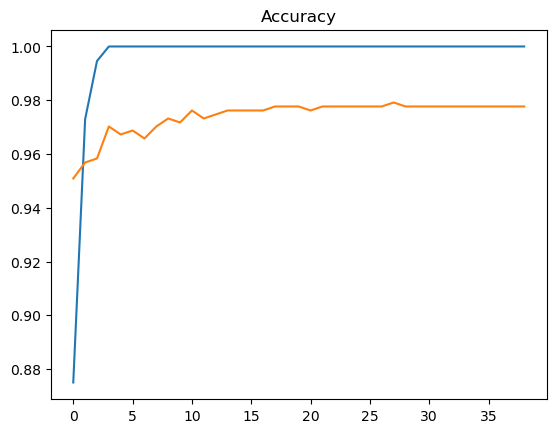

In [12]:
plt.title("Accuracy")
plt.plot(result.history["accuracy"])
plt.plot(result.history["val_accuracy"])
plt.show()

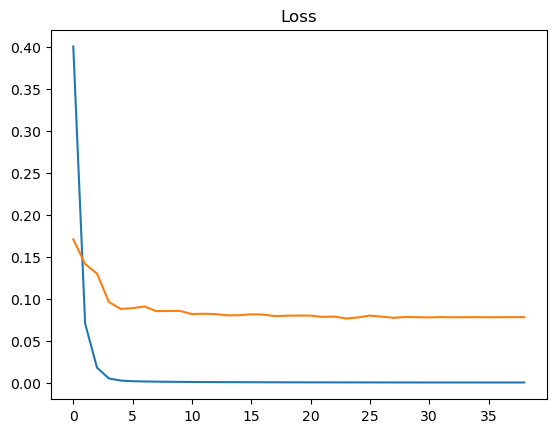

In [13]:
plt.title("Loss")
plt.plot(result.history["loss"])
plt.plot(result.history["val_loss"])
plt.show()

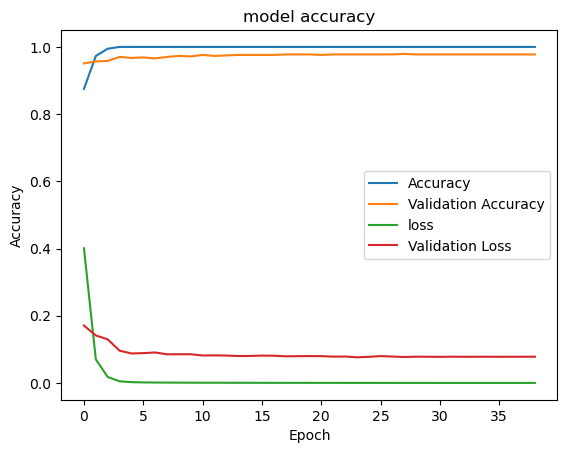

In [14]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [15]:
model.save("model_resnet50.h5")

22/22 [==============================] - 11s 377ms/step


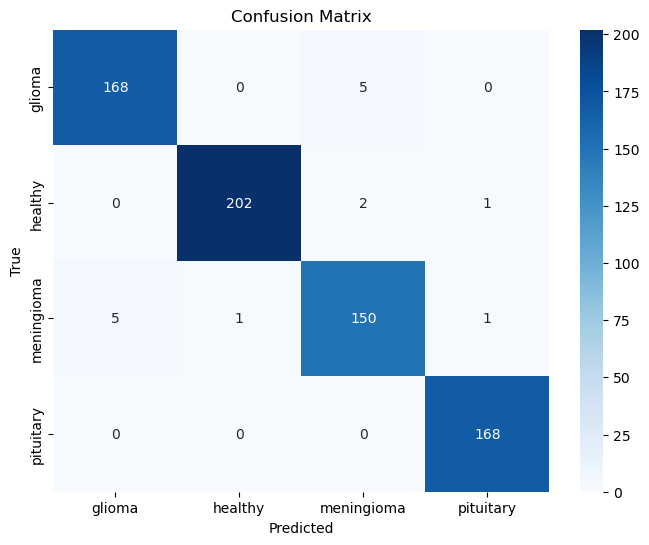

              precision    recall  f1-score   support

      glioma       0.97      0.97      0.97       173
     healthy       1.00      0.99      0.99       205
  meningioma       0.96      0.96      0.96       157
   pituitary       0.99      1.00      0.99       168

    accuracy                           0.98       703
   macro avg       0.98      0.98      0.98       703
weighted avg       0.98      0.98      0.98       703



In [16]:
predictions = model.predict(test_data)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

In [17]:
output_class = ["glioma", "healthy", "meningioma","pituitary"]

def preprocessing_input(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img) # VGG16 preprocess_input
    return img

def plot_images(original, preprocessed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Remove the batch dimension for display
    preprocessed = np.squeeze(preprocessed, axis=0)

    axs[1].imshow(preprocessed)
    axs[1].set_title('Preprocessed Image')
    axs[1].axis('off')

    plt.show()

def predict_user(img_path):
    img = preprocessing_input(img_path)
    plot_images(Image.open(img_path), img)
    predicted_array = model.predict(img)
    predicted_value = output_class[np.argmax(predicted_array)]
    predicted_accuracy = round(np.max(predicted_array) * 100, 2)
    print("Your waste material is", predicted_value, "with", predicted_accuracy, "% accuracy.")

## Train new data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


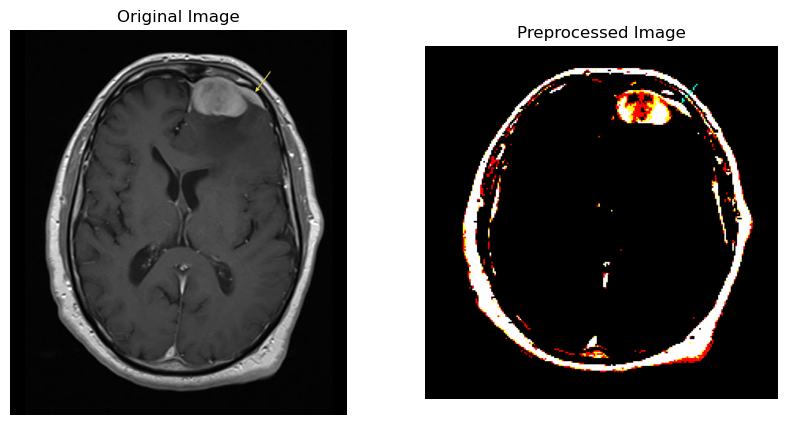

1/1 [==============================] - 5s 5s/step
Your waste material is meningioma with 65.83 % accuracy.


In [18]:
predict_user('meningioma.jpeg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


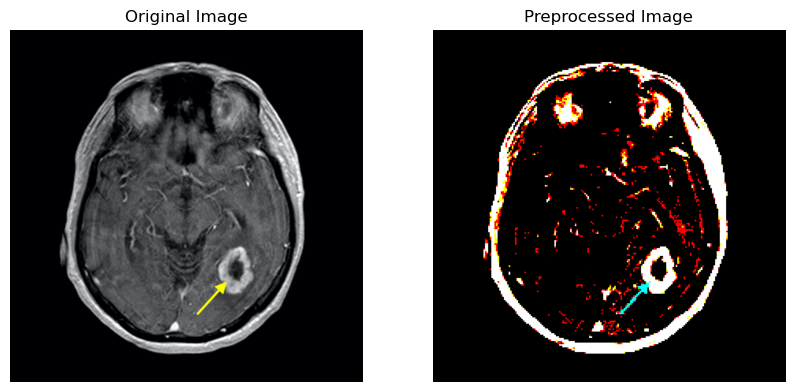

1/1 [==============================] - 0s 35ms/step
Your waste material is glioma with 99.29 % accuracy.


In [19]:
predict_user('glioma.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


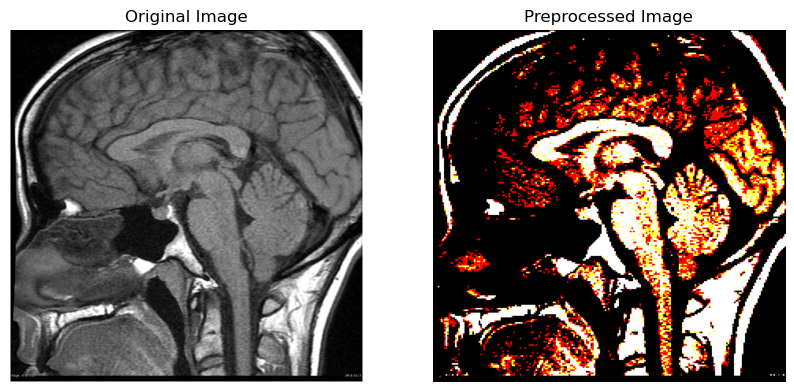

1/1 [==============================] - 0s 28ms/step
Your waste material is pituitary with 98.55 % accuracy.


In [20]:
predict_user('pituitary.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


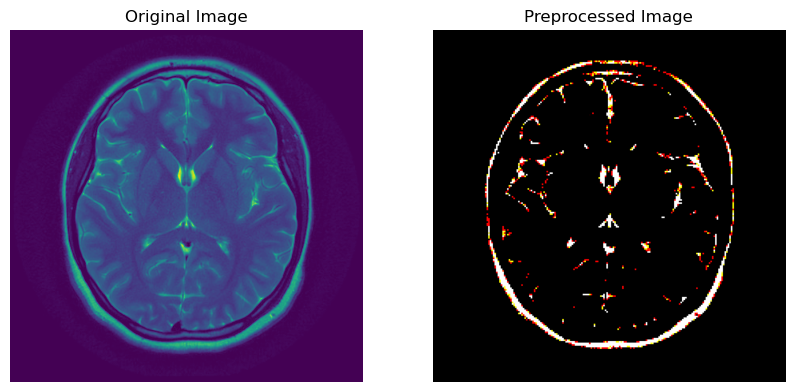

1/1 [==============================] - 0s 28ms/step
Your waste material is healthy with 100.0 % accuracy.


In [24]:
predict_user('normal.jpeg')